## Text mining with Python - from scraping news to sentiment scores

### Dependencies

In [3]:
import re
import csv
import pickle
import time
import pprint
from collections import Counter
from datetime import datetime, timedelta
from urllib.request import urlopen

from bs4 import BeautifulSoup  

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

import spacy
# only run line 21 if language model has not been pre-installed
# !python -m spacy download en_core_web_lg
spacy_nlp = spacy.load('en_core_web_md')
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
spacy.prefer_gpu()

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tag.perceptron import PerceptronTagger
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

from dictionaries import lexicon, negate 
# line 35 imports our proprietary sentiment algorithm
from sentiment_algos import proprietary_sentiment_normalised

from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marceldietsch/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Scraping news articles and calculating sentiment 
- any news article related to the company "Shell"
- source: Singapore Business Times
- use out-of-the-box sentiment libraries (NLTK, Textblob) and my proprietary one

In [16]:
def scraper(keyword):
    """
    takes search term for Business Times (Singapore) news articles, 
    runs scraper through 10 pages of the archive and
    returns dictionary with date (key) and article (value)
    """
    
    date_sentiments = {}
    article_text = {}
    counter = 1

    for i in range(1,9):
        
        page = urlopen('https://www.businesstimes.com.sg/search/'+ keyword +'?page='+str(i)).read()
        soup = BeautifulSoup(page, features="html.parser")
        posts = soup.findAll("div", {"class": "media-body"})
        
        for post in posts:
            
            time.sleep(2)
            url = post.a['href']
            date = post.time.text
            print("Article:", counter, "|", date, "URL:", url[8:65] + "...")
            counter += 1
            
            try:
                link_page = urlopen(url).read()
            except:
                url = url[:-2]
                link_page = urlopen(url).read()
                
            link_soup = BeautifulSoup(link_page)
            sentences = link_soup.findAll("p")
            passage = ""
            
            for sentence in sentences:
                passage += sentence.text
            
            article_text.setdefault(date, []).append(passage)

    articles = {}
    
    for k,v in article_text.items():
        articles[datetime.strptime(k, '%d %b %Y').date() + timedelta(days=1)] = v 
    
    return articles

In [17]:
articles = scraper("shell")

Article: 1 | 15 Jul 2019 URL: www.businesstimes.com.sg/energy-commodities/shell-reports...
Article: 2 | 12 Jun 2019 URL: www.businesstimes.com.sg/energy-commodities/shell-ships-l...
Article: 3 | 08 Jun 2019 URL: www.businesstimes.com.sg/energy-commodities/shell-expands...
Article: 4 | 07 Jun 2019 URL: www.businesstimes.com.sg/energy-commodities/shell-boosts-...
Article: 5 | 29 May 2019 URL: www.businesstimes.com.sg/energy-commodities/ema-psa-shell...
Article: 6 | 28 May 2019 URL: www.businesstimes.com.sg/energy-commodities/ema-strikes-e...
Article: 7 | 24 May 2019 URL: www.businesstimes.com.sg/energy-commodities/shell-sees-si...
Article: 8 | 21 May 2019 URL: www.businesstimes.com.sg/energy-commodities/activists-dem...
Article: 9 | 09 May 2019 URL: www.businesstimes.com.sg/energy-commodities/shell-to-shut...
Article: 10 | 03 May 2019 URL: www.businesstimes.com.sg/energy-commodities/shell-pursuin...
Article: 11 | 12 Apr 2019 URL: www.businesstimes.com.sg/energy-commodities/shell-sells-s.

In [36]:
df = pd.DataFrame.from_dict(articles, columns=['1', '2'], orient='index')
df['content'] = df['1'] + ' ' + df['2'].fillna('')
df.drop(columns=['1', '2'], inplace=True)

In [37]:
f = open('data/df.pkl', 'wb')
pickle.dump(df, f)
f.close()

In [38]:
pd.options.display.max_colwidth = 110
df.head(5)

,content
2019-07-16,[SINGAPORE] A unit at Royal Dutch Shell's Pulau Bukom refinery and petrochemical complex experienced an op...
2019-06-13,MelbourneROYAL Dutch Shell on Monday shipped the long-awaited first cargo of liquefied natural gas (LNG) f...
2019-06-09,SingaporeSHELL has increased the storage capacity at its Singapore Bukom refinery by nearly 1.3 million ba...
2019-06-08,SHELL said on Thursday night that it has increased the storage capacity at its Singapore Bukom refinery by...
2019-05-30,SingaporeSINGAPORE'S Energy Market Authority (EMA) on Tuesday said it is partnering PSA Singapore and Shel...


### Take one article and show NLP tools on this example

In [39]:
spacy_nlp.pipe_names

['tagger', 'parser', 'ner']

In [40]:
sample = df.iloc[0]['content']
print(sample)

[SINGAPORE] A unit at Royal Dutch Shell's Pulau Bukom refinery and petrochemical complex experienced an operational upset on Sunday, a company spokeswoman told Reuters on Monday."On July 14 at approximately 2pm, the Pulau Bukom manufacturing site experienced an operational upset at one of its units, which has resulted in flaring," she said."No injuries have been reported and the relevant authorities have been notified," she said, adding that the rest of the site's operations had not been affected.It was not immediately clear which unit was down. The spokeswoman declined to provide details of the unit citing commercial confidentiality reasons.The Pulau Bukom manufacturing site is an integrated refinery and chemicals site and can process up to 500,000 barrels per day of oil.Bukom is Shell's largest wholly-owned refinery globally in terms of crude distillation capacity, according to the company website.Typically, any unexpected outage at the refinery boosts margins for Asian oil products.

In [41]:
doc = spacy_nlp(sample)

#### Show tokens, lemmatised tokens with stopword removal

In [42]:
tokens = [token.text for token in doc]
print(tokens[:25])

['[', 'SINGAPORE', ']', 'A', 'unit', 'at', 'Royal', 'Dutch', 'Shell', "'s", 'Pulau', 'Bukom', 'refinery', 'and', 'petrochemical', 'complex', 'experienced', 'an', 'operational', 'upset', 'on', 'Sunday', ',', 'a', 'company']


In [43]:
tokens = [token.lemma_ for token in doc if not token.is_stop]
print(tokens[:25])

['[', 'SINGAPORE', ']', 'unit', 'Royal', 'Dutch', 'Shell', 'Pulau', 'Bukom', 'refinery', 'petrochemical', 'complex', 'experience', 'operational', 'upset', 'Sunday', ',', 'company', 'spokeswoman', 'tell', 'Reuters', 'Monday."On', 'July', '14', 'approximately']


#### Show extracted noun chunks, document split into sentences and named-entity recognition

In [44]:
chunks = [chunk.text for chunk in doc.noun_chunks]
print(chunks[3:15])

['petrochemical complex', 'an operational upset', 'Sunday', 'a company spokeswoman', 'Reuters', 'Monday."On July', 'approximately 2pm', 'the Pulau Bukom manufacturing site', 'an operational upset', 'its units', '" she', 'the relevant authorities']


In [45]:
sentences = [sent.string.strip() for sent in doc.sents]
pprint.pprint(sentences[:3])

['[SINGAPORE]',
 "A unit at Royal Dutch Shell's Pulau Bukom refinery and petrochemical complex "
 'experienced an operational upset on Sunday, a company spokeswoman told '
 'Reuters on Monday."On July 14 at approximately 2pm, the Pulau Bukom '
 'manufacturing site experienced an operational upset at one of its units, '
 'which has resulted in flaring," she said."No injuries have been reported and '
 'the relevant authorities have been notified," she said, adding that the rest '
 "of the site's operations had not been affected.",
 'It was not immediately clear which unit was down.']


In [46]:
NER_labels = [(X.text, X.label_, spacy.explain(X.label_)) for X in doc.ents]
NER_labels[:10]

[('SINGAPORE', 'GPE', 'Countries, cities, states'),
 ("Royal Dutch Shell's", 'ORG', 'Companies, agencies, institutions, etc.'),
 ('Pulau Bukom', 'ORG', 'Companies, agencies, institutions, etc.'),
 ('Sunday', 'DATE', 'Absolute or relative dates or periods'),
 ('Reuters', 'ORG', 'Companies, agencies, institutions, etc.'),
 ('July 14', 'DATE', 'Absolute or relative dates or periods'),
 ('approximately 2pm', 'TIME', 'Times smaller than a day'),
 ('Pulau Bukom', 'ORG', 'Companies, agencies, institutions, etc.'),
 ('one', 'CARDINAL', 'Numerals that do not fall under another type'),
 ('Pulau Bukom', 'ORG', 'Companies, agencies, institutions, etc.')]

In [47]:
displacy.render(spacy_nlp(str(sentences[:13])), jupyter=True, style='ent')

### Named-entity recognition (NER) stats for all documents
- convert all rows of dataframe into a string that is passed into Spacy
- Named-entity recognition category counter, i.e. how many companies, countries, dates etc were mentioned
- Named-entity recognition counter (before and after applying lemmatiser and stopword removal)

In [21]:
whole = spacy_nlp(df.content.str.cat(sep=' '))

In [22]:
labels = [spacy.explain(x.label_) for x in whole.ents]
Counter(labels)

Counter({'Countries, cities, states': 370,
         'Companies, agencies, institutions, etc.': 1121,
         'Absolute or relative dates or periods': 674,
         'Times smaller than a day': 16,
         'Numerals that do not fall under another type': 253,
         'Measurements, as of weight or distance': 90,
         'People, including fictional': 259,
         'Nationalities or religious or political groups': 110,
         'Objects, vehicles, foods, etc. (not services)': 32,
         'Non-GPE locations, mountain ranges, bodies of water': 97,
         'Monetary values, including unit': 235,
         '"first", "second", etc.': 67,
         'Buildings, airports, highways, bridges, etc.': 28,
         'Percentage, including "%"': 12,
         'Named documents made into laws.': 6,
         'Named hurricanes, battles, wars, sports events, etc.': 1})

In [26]:
items = [x.text for x in whole.ents]
Counter(items).most_common(10)

[('Shell', 254),
 ('2019', 86),
 ('SINGAPORE PRESS HOLDINGS LTD', 80),
 ('LNG', 56),
 ('first', 48),
 ('Singapore', 45),
 ('Digital News', 35),
 ('two', 34),
 ('Tuesday', 33),
 ('REUTERSSPH Digital News', 28)]

In [28]:
words = [token.lemma_ for token in whole.doc if token.is_stop != True and token.is_punct != True]
Counter(words).most_common(10)

[('Shell', 352),
 ('say', 283),
 ('year', 181),
 ('oil', 180),
 ('company', 152),
 ('gas', 137),
 ('project', 115),
 ('us$', 114),
 ('billion', 107),
 ('cent', 107)]

## Apply Spacy pipeline to whole DF + calculate sentiment
- apply lemmatiser and stopword removal
- convert Spacy object back to string so sentiment algorithsm can be run
- apply sentiment algorithms, two out of the box (TextBlob and NLTK) and
 and our proprietary one

In [30]:
%%time

df['spacy_tokens'] = df['content'].apply(spacy_nlp)


def spacy_lemma_stopwords(text):
    """remove stopwords and lemmatise all spacy tokens"""
    return [token.lemma_ for token in text if not token.is_stop]

spacy_process = lambda x: spacy_lemma_stopwords(x)
df["spacy_processed"] = df.spacy_tokens.apply(spacy_process)


def spacy_to_string(text):
    """convert lemmatised Spacy tokens back to string"""
    return ' '.join(text)


spacy_to_str = lambda x: spacy_to_string(x)
df["spacy_string"] = df.spacy_processed.apply(spacy_to_str)

# Apply sentiment algorithms

TB = lambda x: round(TextBlob(x).sentiment.polarity, 3)
NLTK = lambda x: round(sia.polarity_scores(x)['compound'], 3)
MD_proprietary = lambda x: round(proprietary_sentiment_normalised(lexicon, x), 3)

df['TextBlob_spacy'] = df.spacy_string.apply(TB)
df['NLTK_spacy'] = df.spacy_string.apply(NLTK)
df['Proprietary_spacy'] = df.spacy_string.apply(MD_proprietary)

df.head()

CPU times: user 5.76 s, sys: 474 ms, total: 6.23 s
Wall time: 6.3 s


,content,spacy_tokens,spacy_processed,spacy_string,TextBlob_spacy,NLTK_spacy,Proprietary_spacy,senti_category_prop_3,senti_category_TB,senti_category_NLTK,senti_category_prop_5,sentiment_label,senti_score_prop_label,senti_score_NLTK_label,senti_score_TB_label
2019-07-16,[SINGAPORE] A unit at Royal Dutch Shell's Pula...,"([, SINGAPORE, ], A, unit, at, Royal, Dutch, S...","[[, SINGAPORE, ], unit, Royal, Dutch, Shell, P...",[ SINGAPORE ] unit Royal Dutch Shell Pulau Buk...,0.001,-0.727,-0.714,negative,neutral,negative,negative,negative,True,True,False
2019-06-13,MelbourneROYAL Dutch Shell on Monday shipped t...,"(MelbourneROYAL, Dutch, Shell, on, Monday, shi...","[MelbourneROYAL, Dutch, Shell, Monday, ship, l...",MelbourneROYAL Dutch Shell Monday ship long - ...,0.055,0.599,-0.400,neutral,neutral,positive,negative,neutral,True,False,True
2019-06-09,SingaporeSHELL has increased the storage capac...,"(SingaporeSHELL, has, increased, the, storage,...","[SingaporeSHELL, increase, storage, capacity, ...",SingaporeSHELL increase storage capacity Singa...,0.079,0.852,1.000,positive,neutral,positive,very positive,positive,True,True,False
2019-06-08,SHELL said on Thursday night that it has incre...,"(SHELL, said, on, Thursday, night, that, it, h...","[SHELL, say, Thursday, night, increase, storag...",SHELL say Thursday night increase storage capa...,0.142,0.977,0.800,positive,neutral,positive,very positive,positive,True,True,False
2019-05-30,SingaporeSINGAPORE'S Energy Market Authority (...,"(SingaporeSINGAPORE, 'S, Energy, Market, Autho...","[SingaporeSINGAPORE, Energy, Market, Authority...",SingaporeSINGAPORE Energy Market Authority ( E...,0.000,0.852,0.000,neutral,neutral,positive,neutral,neutral,True,False,True


### Sentiment visualisation over time

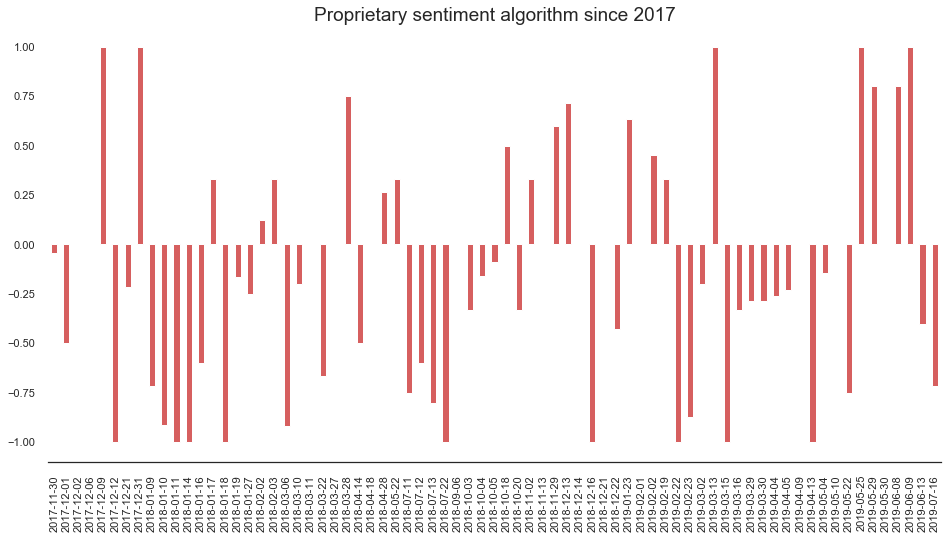

In [34]:
sns.set(style="white", palette="muted", color_codes=True)

ax = df.Proprietary_spacy.plot.bar(figsize=(16, 8), color='r')
ax.invert_xaxis()
plt.title("Proprietary sentiment algorithm since 2017", fontsize=19)

sns.despine(left=True)

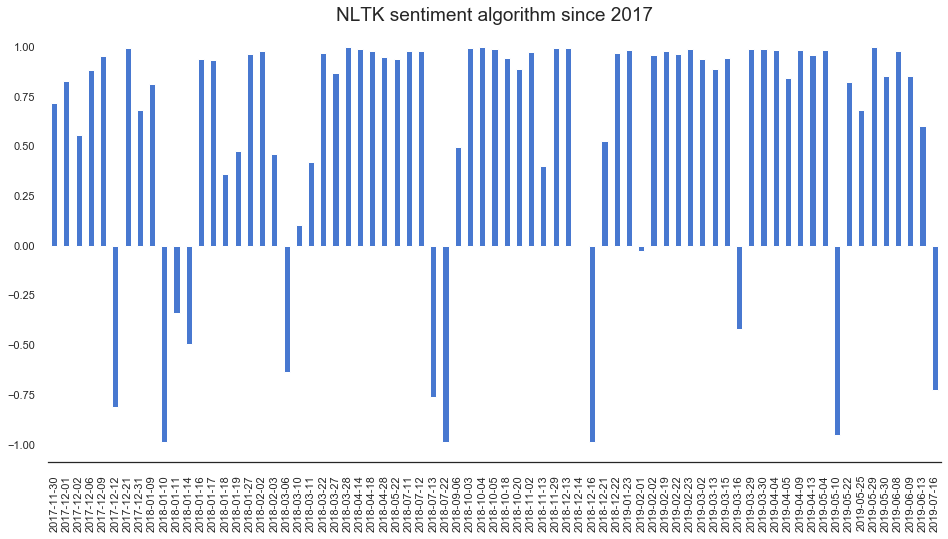

In [35]:
ax = df.NLTK_spacy.plot.bar(figsize=(16, 8), color='b')
ax.invert_xaxis()
plt.title("NLTK sentiment algorithm since 2017", fontsize=19)
sns.despine(left=True)

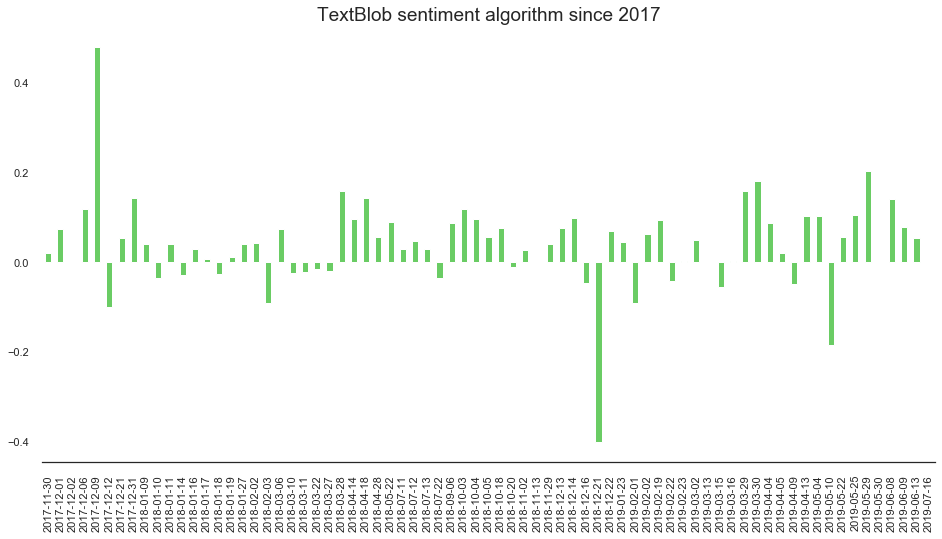

In [36]:
ax = df.TextBlob_spacy.plot.bar(figsize=(16, 8), color='g')
ax.invert_xaxis()
plt.title("TextBlob sentiment algorithm since 2017", fontsize=19)
sns.despine(left=True)

### Sentiment categories, histograms and distributions
- turning numeric scores into categories - "positive", "neutral" and "negative"
- for my own sentiment algorithm ("proprietary") I also created five categories, including "very positive" and "very negative"
- visualising both numeric scores and categories

In [37]:
positive_bound = 0.4
negative_bound = -0.4

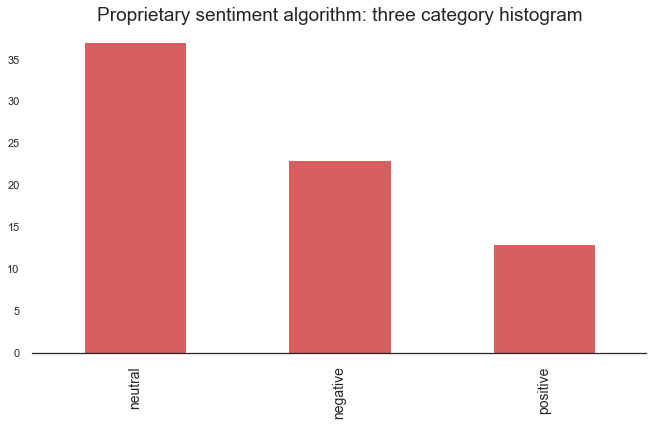

In [77]:
df['senti_category_prop_3'] = \
   ['positive' if x > positive_bound else 'negative' if x < negative_bound else 'neutral' \
    for x in df['Proprietary_spacy']]

ax = df.senti_category_prop_3.value_counts().plot.bar(figsize=(11,6), color='r')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.title("Proprietary sentiment algorithm: three category histogram", fontsize=19)
sns.despine(left=True)
plt.show()

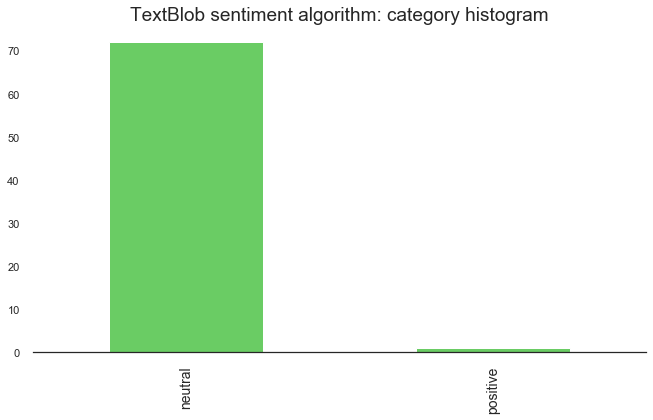

In [75]:
df['senti_category_TB'] = \
   ['positive' if x > positive_bound else 'negative' if x < negative_bound else 'neutral' \
    for x in df['TextBlob_spacy']]

ax = df.senti_category_TB.value_counts().plot.bar(figsize=(11,6), color='g')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.title("TextBlob sentiment algorithm: category histogram", fontsize=19)
sns.despine(left=True)
plt.show()

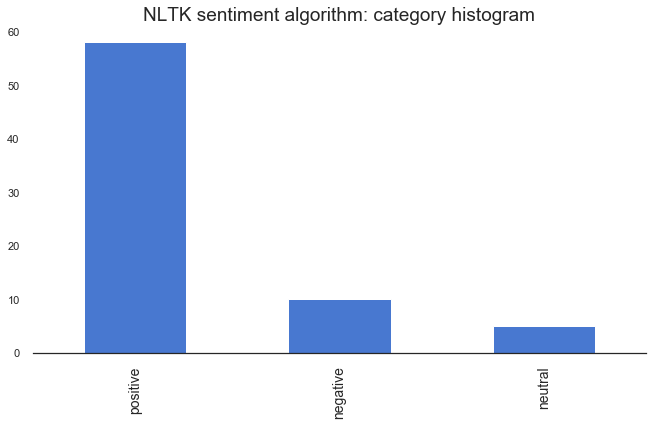

In [76]:
ax = df.senti_category_NLTK.value_counts().plot.bar(figsize=(11,6), color='b')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.title("NLTK sentiment algorithm: category histogram", fontsize=19)
sns.despine(left=True)
plt.show()

#### This is the same proprietary algorithm as above but with five categories

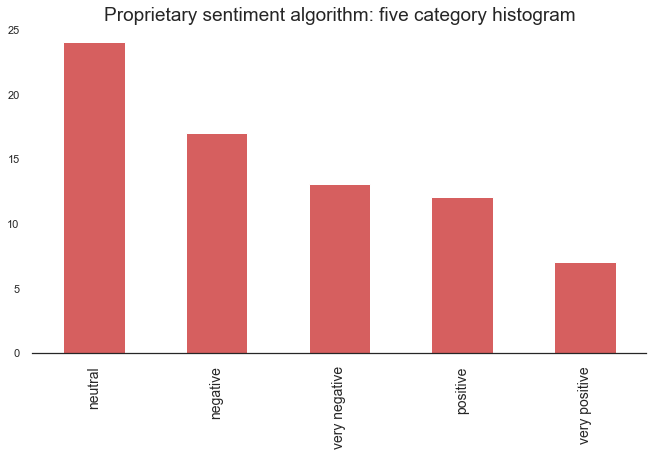

In [78]:
df['senti_category_prop_5'] = \
   ['very positive' if x > 0.75 else 'positive' if x > 0.25 \
    else 'very negative' if x < -0.75 else 'negative' if x < -0.25 else 'neutral' \
    for x in df['Proprietary_spacy']]

ax = df.senti_category_prop_5.value_counts().plot.bar(figsize=(11,6), color='r')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.title("Proprietary sentiment algorithm: five category histogram", fontsize=19)
sns.despine(left=True)
plt.show()

#### This is a histogram of the proprietary algorithm's numeric scores with 15 bins

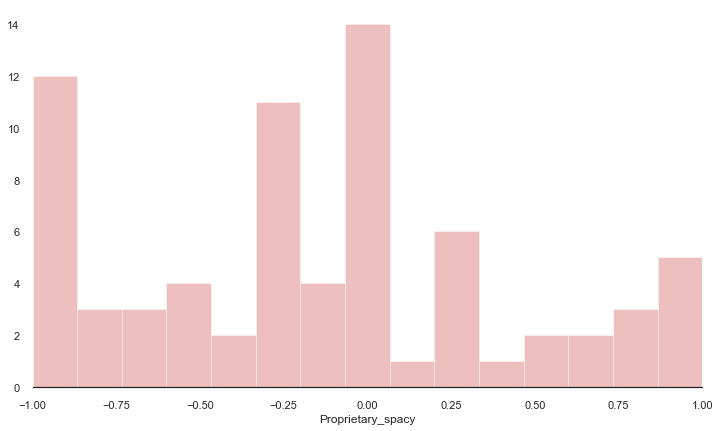

In [42]:
sns.set(style="white", palette="muted", color_codes=True)

plt.figure(figsize=(12,7))
ax = sns.distplot(df.Proprietary_spacy, bins=15, kde=False, color='r')
ax.set_xlim(-1,1)
sns.despine(left=True)

#### These two charts show the distribution of all three sentiment algorithms
- first is a histogram with discrete values (different bin sizes)
- and second transformed into a continuous probability density function (PDF)

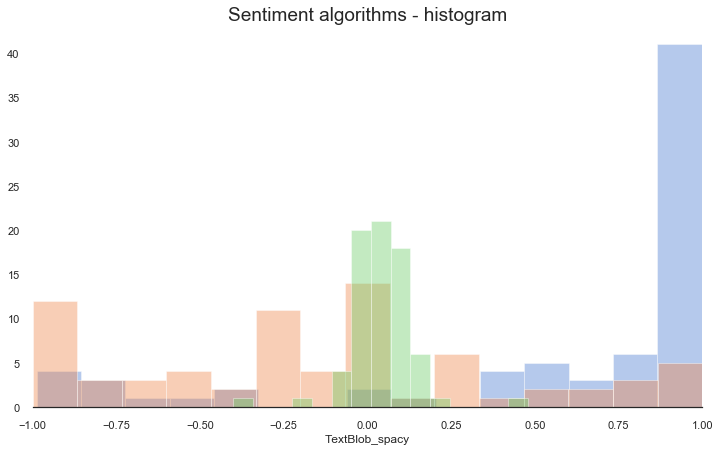

In [69]:
sns.set(style="white", palette="muted", color_codes=True)

plt.figure(figsize=(12,7))
ax = sns.distplot(df.NLTK_spacy, bins=15, kde=False)
ax2 = sns.distplot(df.Proprietary_spacy, bins=15, kde=False)
ax2 = sns.distplot(df.TextBlob_spacy, bins=15, kde=False)
plt.title("Sentiment algorithms - histogram", fontsize=19)
ax.set_xlim(-1,1)
sns.despine(left=True)

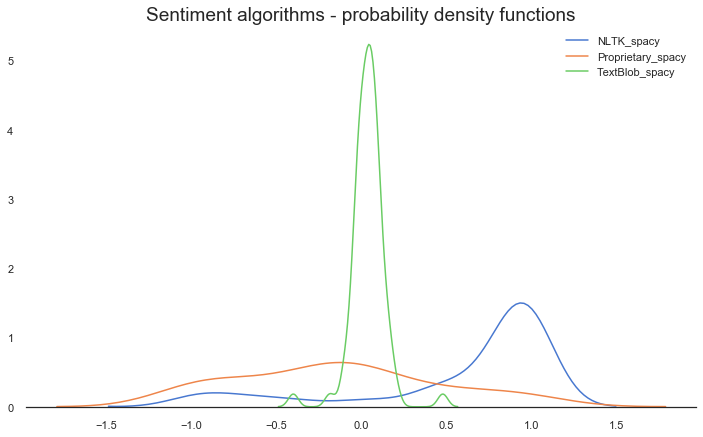

In [68]:
sns.set(style="white", palette="muted", color_codes=True)

plt.figure(figsize=(12,7))
ax = sns.kdeplot(df.NLTK_spacy)
ax2 = sns.kdeplot(df.Proprietary_spacy)
ax2 = sns.kdeplot(df.TextBlob_spacy)
plt.title("Sentiment algorithms - probability density functions", fontsize=19)
sns.despine(left=True)

## Checking sentiment score accuracy with manual labels

In [292]:
df['sentiment_label'] = df['Proprietary_spacy'].astype(str)

In [293]:
article_count = 0
pprint.pprint(df.content[article_count])

("[SINGAPORE] A unit at Royal Dutch Shell's Pulau Bukom refinery and "
 'petrochemical complex experienced an operational upset on Sunday, a company '
 'spokeswoman told Reuters on Monday."On July 14 at approximately 2pm, the '
 'Pulau Bukom manufacturing site experienced an operational upset at one of '
 'its units, which has resulted in flaring," she said."No injuries have been '
 'reported and the relevant authorities have been notified," she said, adding '
 "that the rest of the site's operations had not been affected.It was not "
 'immediately clear which unit was down. The spokeswoman declined to provide '
 'details of the unit citing commercial confidentiality reasons.The Pulau '
 'Bukom manufacturing site is an integrated refinery and chemicals site and '
 "can process up to 500,000 barrels per day of oil.Bukom is Shell's largest "
 'wholly-owned refinery globally in terms of crude distillation capacity, '
 'according to the company website.Typically, any unexpected outage at t

In [295]:
classifier = input("Classify sentiment: (negative, neutral, positive): \n")

df.iat[article_count, 11] = classifier

print("Manual label:                     ", df.iloc[article_count]['sentiment_label'])
print("Sentiment category (proprietary): ", df.iloc[article_count]['senti_category_prop_3'])
print("Sentiment category (NLTK):        ", df.iloc[article_count]['senti_category_NLTK'])

Classify sentiment: (negative, neutral, positive): 
negative
Manual label:                      negative
Sentiment category (proprietary):  negative
Sentiment category (NLTK):         negative


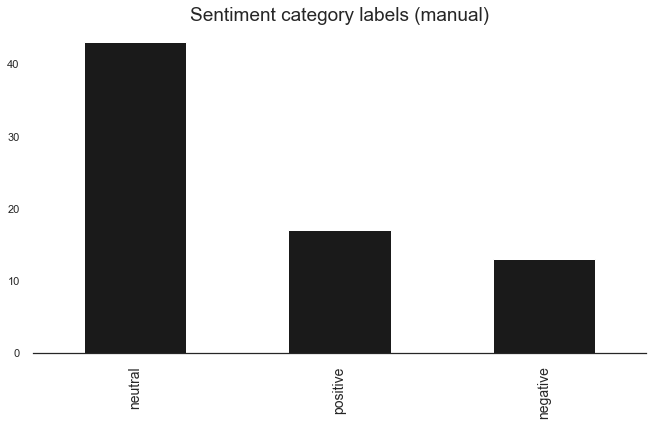

In [79]:
ax = df.sentiment_label.value_counts().plot.bar(figsize=(11,6), color='k')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.title("Sentiment category labels (manual)", fontsize=19)
sns.despine(left=True)
plt.show()

In [253]:
f = open('data/df_senti_labelled.pkl', 'wb')
pickle.dump(df, f)
f.close()

In [20]:
#f = open('data/df_senti_labelled.pkl', 'rb')
#df = pickle.load(f)
#f.close()

### Check how manual sentiment labels compare to algorithms

In [304]:
df['senti_score_prop_label'] = df.apply(lambda x: x['senti_category_prop_3'] == x['sentiment_label'], axis=1)
df['senti_score_NLTK_label'] = df.apply(lambda x: x['senti_category_NLTK'] == x['sentiment_label'], axis=1)
df['senti_score_TB_label'] = df.apply(lambda x: x['senti_category_TB'] == x['sentiment_label'], axis=1)

In [305]:
df.senti_score_prop_label.value_counts()

True     51
False    22
Name: senti_score_prop_label, dtype: int64

In [306]:
df.senti_score_NLTK_label.value_counts()

False    46
True     27
Name: senti_score_NLTK_label, dtype: int64

In [307]:
df.senti_score_TB_label.value_counts()

True     42
False    31
Name: senti_score_TB_label, dtype: int64

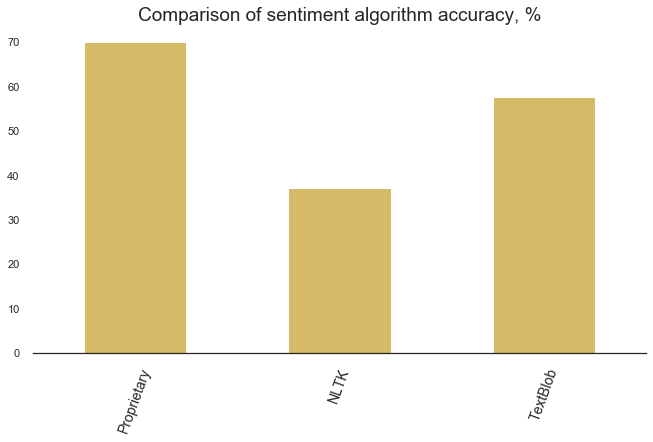

In [80]:
sns.set(style="white", palette="muted", color_codes=True)

accuracy_df = pd.DataFrame({'accuracy': [51/73*100, 27/73*100, 42/73*100]},
                        index=['Proprietary', 'NLTK', 'TextBlob'])
ax = accuracy_df.plot.bar(y='accuracy', figsize=(11, 6), legend=False, color='y')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=70, fontsize=14)
plt.title("Comparison of sentiment algorithm accuracy, %", fontsize=19)
sns.despine(left=True)

In [388]:
f = open('data/df_senti_labelled.pkl', 'wb')
pickle.dump(df, f)
f.close()